<a href="https://colab.research.google.com/github/Zhdanko-Gleb/Matplotlib/blob/master/RRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Здесь будет код для реализации алгоритма RRT. Я решил, что на входе подаются: 

1.   Размеры поля
2. Кол-во препятсвий
3.   Препятсвия
4.   Начальная позиция
5. Конечная позиция


Пример входног файла: 


```
bordersize: [-10,10,-10,10]
num_obstacles: 2
obstacles:
  - ob: 1
    points: [[-1,1,1,-1,-1],[1,1,-1,-1,1]]
  - ob: 2
    points: [[-3,5,-1,-3],[2,8,1,2]]
start: [3,3]
finish: [5,5]
```




In [49]:
import yaml
from pprint import pprint
import matplotlib.pyplot as plt
import random
import math
random.seed(11)
from matplotlib.pyplot import figure
from collections import defaultdict
from shapely.geometry import Point, Polygon,LineString

radius = 0.9
steps = 2000
dist_step = 1
probability = 1

In [50]:
def read(name):
    with open(name) as f:
        templates = yaml.safe_load(f)
        bordersize = templates['bordersize']
        start = templates['start']
        finish = templates['finish']
        num_obs = templates['num_obstacles']
        obstacles = templates['obstacles']
    return bordersize,start,finish,num_obs,obstacles

In [51]:
def write(data):
    with open('output.yaml', 'w') as f:
        yaml.dump(data, f, default_flow_style=False)

In [52]:
def draw_graph(graph,parent):
    for i in graph:
        if (i[0],i[1]) in parent:
            plt.plot([parent[(i[0],i[1])][0],i[0],],[parent[(i[0],i[1])][1],i[1]],'-o',markersize = '2',linewidth=1,color='blue')

In [53]:
def draw_obstacles(obstacles,n):
    for i in range(n):
        obs = obstacles[i]['points']
        x = obs[0]
        y = obs[1]
        plt.plot(x, y,'r')

In [54]:
def draw_path(path):
    x = [i[0] for i in path]
    y = [i[1] for i in path]
    plt.plot(x,y,'black')

In [55]:
def distance(a,b,x,y):
    return math.sqrt((a-x)**2 + (b-y)**2)

In [56]:
def find_nearest_vertex_rrt(g,x,y):
    min_dist = 10000000
    v_x = 0
    v_y = 0
    for vert in g:
        a = distance(vert[0],vert[1],x,y)
        if a<min_dist:
            min_dist = a
            v_x = vert[0]
            v_y = vert[1]
    return v_x,v_y

In [57]:
def find_nearest_vertex_rrt_star(g,x,y,neighbourhood_dist):
    neighbourhood = []
    for vert in g:
        a = distance(vert[0],vert[1],x,y)
        if a<neighbourhood_dist:
            neighbourhood.append([vert,a])
    return neighbourhood

In [58]:
def move(a,b,x,y,dist):
    v1 = a-x
    v2 = b-y
    norm_v = math.sqrt(v1*v1+v2*v2)
    return [round(x+ (v1/norm_v)*dist,2), round(y+(v2/norm_v)*dist,2)]

In [59]:
def inPolygon(x, y,obstacles):
    c=0
    for obs in obstacles: 
        xp = obs['points'][0]
        yp = obs['points'][1]
        for i in range(len(xp)):
            if (x==xp[i]) and (y == yp[i]):
                return True
            if (((yp[i]<y and y<yp[i-1]) or (yp[i-1]<y and y<yp[i])) and 
                (x > (xp[i-1] - xp[i]) * (y - yp[i]) / (yp[i-1] - yp[i]) + xp[i])):
                c = 1 - c   
        if c%2 == 1: 
            return True 
    return False

In [60]:
def check_points(x, y,obstacles):
    p = Point((x,y))
    for obs in obstacles: 
        a = obs['points'][0]
        b = obs['points'][1]
        z = [(a[i],b[i]) for i in range(1,len(a))]
        poly = Polygon(z)
        if (poly.contains(p)) or (poly.touches(p)):
            return True
    return False

In [61]:
def check_borders(bordersize,vert):
    x = vert[0]
    y = vert[1]
    if x<=bordersize[0] or x>=bordersize[1]:
        return True
    if y<=bordersize[2] or y>=bordersize[3]:
        return True
    return False

In [62]:
def check_final(a,b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 < radius**2

In [63]:
def build_path(graph,parent,final,start):
    path = []
    q = final
    while not(q[0]== start[0] and q[1]==start[1]):
        path.append(q)
        q = parent[(q[0],q[1])]
    path.append(start)
    return path

In [64]:
def edge_intersec(p1,p2,obstacles):
    edge = LineString([p1,p2])
    for obs in obstacles:
        x = obs['points'][0]
        y = obs['points'][1]
        for i in range(1,len(x)):
            a = Point((x[i-1]),(y[i-1]))
            b = Point((x[i]),(y[i]))
            line = LineString([a,b])
            if (edge.intersects(line)) or (edge.touches(line)):
                return True
    else: 
        return False

In [65]:
def rrt(bordersize,start,finish,num_obs,obstacles,dist, epsilon,steps):
    # epsilon - для вероятности, потом можно с вероятностью e приближаться к цели
    # dist - длина каждого шага
    path = []
    graph = []
    graph.append(start)
    parent = {}
    #childs = defaultdict(list)
    final_point = 0
    mindist = radius
    k = 0
    while k<steps: 
        x = round(random.uniform(bordersize[0],bordersize[1]),3)
        y = round(random.uniform(bordersize[2],bordersize[3]),3)
        near_point_x,near_point_y = find_nearest_vertex_rrt(graph,x,y)
        new_vert = move(x,y,near_point_x,near_point_y,dist)
        k+=1
        if check_borders(bordersize,new_vert):
            continue
        if check_points(new_vert[0],new_vert[1],obstacles):
            continue
        #Проверка пересекает ли новое ребро граф
        if edge_intersec(new_vert,(near_point_x,near_point_y),obstacles):
            continue
        graph.append(new_vert)
        if (check_final(finish,new_vert)) and (distance(finish[0],finish[1],new_vert[0],new_vert[1])<mindist):
            final_point = new_vert
            mindist = distance(finish[0],finish[1],new_vert[0],new_vert[1])
        parent[(new_vert[0],new_vert[1])] = (near_point_x,near_point_y)

        if final_point!=0: 
            break
    if final_point!=0:
        path = build_path(graph,parent,final_point,start)
    return graph,parent,path,k

In [87]:
def rrt_star(bordersize,start,finish,num_obs,obstacles,dist, epsilon,steps):
    # epsilon - для вероятности, потом можно с вероятностью e приближаться к цели
    # dist - длина каждого шага
    path = []
    graph = []
    graph.append(start)
    parent = {}
    final_point = 0
    mindist = radius
    neighbourhood_dist = dist
    cost = {}
    cost[(start[0],start[1])] = 0
    
    k = 0
    while k<steps: 
        x = round(random.uniform(bordersize[0],bordersize[1]),3)
        y = round(random.uniform(bordersize[2],bordersize[3]),3)
        near_point_x,near_point_y = find_nearest_vertex_rrt(graph,x,y)
        new_vert = move(x,y,near_point_x,near_point_y,dist)
        k+=1
        if check_borders(bordersize,new_vert):
            continue
        if check_points(new_vert[0],new_vert[1],obstacles):
            continue
        #Ишем самого близкого соседа с минимальной стоимостью пути от начальной вершины
        neighbourhood = find_nearest_vertex_rrt_star(graph,new_vert[0],new_vert[1],neighbourhood_dist)
        min_cost = dist*100
        nearest_vertex = [near_point_x,near_point_y]
        for vert,n_dist in neighbourhood:
            #Проверка пересекает ли новое ребро граф
            if edge_intersec(new_vert,vert,obstacles):
                continue
            if cost[(vert[0],vert[1])]+n_dist<min_cost:
                nearest_vertex = vert
                min_cost = cost[(vert[0],vert[1])]+n_dist
        if min_cost==dist*100:
            continue
        cost[(new_vert[0],new_vert[1])] = min_cost
        parent[(new_vert[0],new_vert[1])] = (nearest_vertex)
        graph.append(new_vert)
        #rewiring
        for vert,n_dist in neighbourhood:
            if  not(edge_intersec(new_vert,vert,obstacles))and (cost[(vert[0],vert[1])]>n_dist+min_cost):
                parent[(vert[0],vert[1])] = (new_vert[0],new_vert[1])
                cost[(vert[0],vert[1])]=n_dist+min_cost
        
        if (check_final(finish,new_vert)) and (distance(finish[0],finish[1],new_vert[0],new_vert[1])<mindist):
            final_point = new_vert
            mindist = distance(finish[0],finish[1],new_vert[0],new_vert[1])

    if final_point!=0:
        path = build_path(graph,parent,final_point,start)
    return graph,parent,path

In [78]:
def main(name,steer, epochs_1):
    [bordersize,start,finish,num_obs,obstacles] = read(name)
    graph,parent,path,epochs = rrt(bordersize,start,finish,num_obs,obstacles,steer,probability,epochs_1)
    data = {'graph':graph,'path':path}
    write(data)
    plt.figure(figsize=(6,6),dpi=100)
    draw_obstacles(obstacles,num_obs)
    draw_graph(graph,parent)
    if path:
        print('Path Length:' + str(len(path)*dist_step)+', Steps: '+str(epochs))
        draw_path(path)
    else:
        print('NO PATH')
    plt.plot(start[0],start[1], marker="*",markersize = '7', markerfacecolor="green")
    plt.plot(finish[0],finish[1], marker="*",markersize = '7', markerfacecolor="red")
    plt.axis(bordersize)
    plt.xticks(range(bordersize[0],bordersize[1]))
    plt.yticks(range(bordersize[2],bordersize[3]))
    plt.grid()
    plt.show()
    return epochs

In [93]:
def main_rrt_star(name,steer, epochs_1):
    [bordersize,start,finish,num_obs,obstacles] = read(name)
    graph,parent,path = rrt_star(bordersize,start,finish,num_obs,obstacles,steer,probability,epochs_1)
    data = {'graph':graph,'path':path}
    write(data)
    plt.figure(figsize=(6,6),dpi=100)
    draw_obstacles(obstacles,num_obs)
    draw_graph(graph,parent)
    if path:
        print('Path Length:' + str(len(path)*dist_step))
        draw_path(path)
    else:
        print('NO PATH')
    plt.plot(start[0],start[1], marker="*",markersize = '7', markerfacecolor="green")
    plt.plot(finish[0],finish[1], marker="*",markersize = '7', markerfacecolor="red")
    plt.axis(bordersize)
    plt.xticks(range(bordersize[0],bordersize[1]))
    plt.yticks(range(bordersize[2],bordersize[3]))
    #plt.grid()
    # plt.savefig('output'+str(i)+'.png')
    plt.show()

NO PATH


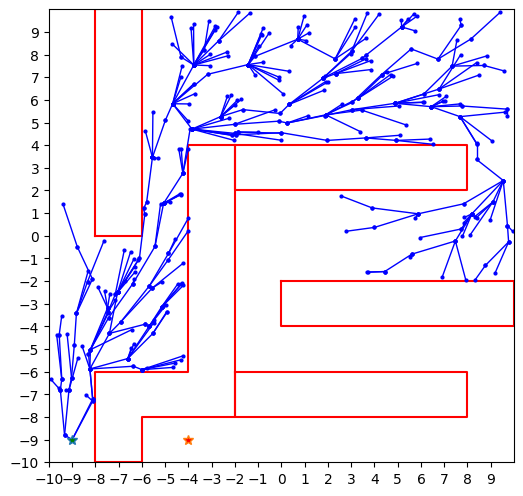

In [94]:
main_rrt_star('input4.yaml',2,1000)

In [ ]:
import pandas as pd

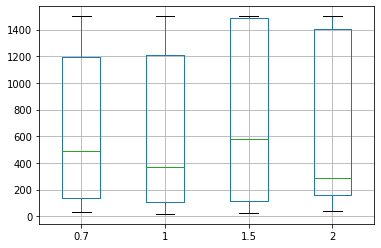

In [ ]:
data.boxplot()

In [ ]:
data.to_csv('data1.csv')

In [ ]:
data2 = pd.read_csv('data2.csv')

In [ ]:
data2.head()

,1,1.5,2,2.5
0,3000,2153,1602,1318
1,3000,2357,1178,3000
2,2766,1935,1280,968
3,2873,2098,2617,2007
4,2262,2133,1059,1456


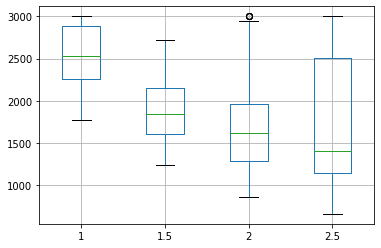

In [ ]:
data2.boxplot()

In [ ]:
data3 = pd.read_csv('data3.csv')

In [ ]:
data3.head()

,1,1.5,2,2.5
0,2941,3000,3000,3000
1,3000,2578,3000,3000
2,3000,1694,2052,3000
3,3000,3000,2404,2483
4,2971,3000,2596,1921


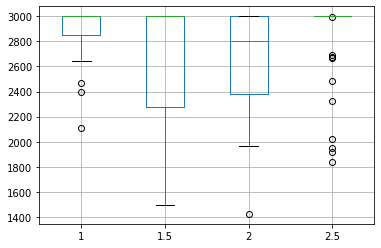

In [ ]:
data3.boxplot()

In [ ]:
data3_2 = pd.read_csv('data3_2.csv')

In [ ]:
data3_2.head()

,1,1.5,2,2.5
0,2179,2547,1897,5000
1,2998,2577,3554,5000
2,3285,2361,2431,5000
3,2252,3361,2265,5000
4,2658,2340,3467,5000


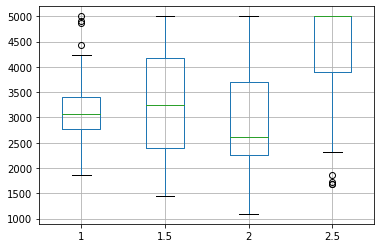

In [ ]:
data3_2.boxplot()

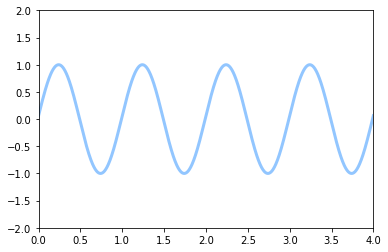

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')
 
 
fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)
 
def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,
 
anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())